In [44]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate

In [30]:
df = pd.read_excel(r"/content/Df.xlsx")
df.drop(columns = ['Unnamed: 0', 'Treatment'], inplace = True)

In [31]:
X = df.iloc[:, 0:4]
y = df.iloc[:,4:14]
feature_names = X.columns.tolist()
target_names  = y.columns.tolist()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [33]:
param_grid = {
    'rf__n_estimators':      [100, 200, 500, 1000],
    'rf__max_depth':         [None, 2,5, 10, 15, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
}

cv_splitter = KFold(n_splits=8, shuffle=True, random_state=0)

In [34]:
y_train_arr = y_train.to_numpy()
y_test_arr  = y_test.to_numpy()

In [35]:
n_targets    = y_train_arr.shape[1]
y_train_pred = np.zeros_like(y_train_arr)
y_test_pred  = np.zeros_like(y_test_arr)
best_models  = {}

In [36]:
# In[2]: Fit a separate RF per target (no MultiOutputRegressor)
for idx, name in enumerate(target_names):
    print(f"Training model for target: {name}")

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('rf',     RandomForestRegressor(random_state=0))
    ])
    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=cv_splitter,
        scoring='neg_root_mean_squared_error',
        return_train_score=True,
        n_jobs=-1,
        verbose=2
    )

    # Fit on the single-column target
    grid.fit(X_train, y_train_arr[:, idx])

    # Save best estimator and predictions
    best_models[name]      = grid.best_estimator_
    y_train_pred[:, idx]   = grid.predict(X_train)
    y_test_pred[:, idx]    = grid.predict(X_test)


Training model for target: Weightloss
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: Firmness
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: TSS
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: pH
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: L
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: a
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: b
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: ΔE
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: TPC
Fitting 8 folds for each of 84 candidates, totalling 672 fits
Training model for target: inhibition
Fitting 8 folds for each of 84 candidates, totalling 672 fits


In [46]:
best_pipe = grid.best_estimator_
best_idx  = grid.best_index_
print(grid.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=10, n_estimators=500,
                                       random_state=0))])


In [38]:
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [45]:
cv_results_all = {}
for idx, name in enumerate(target_names):
    cv_results_all[name] = cross_validate(
        best_models[name],            # the fitted pipeline for this target
        X_train,
        y_train_arr[:, idx],          # numpy array of the idx-th target
        cv=cv_splitter,
        scoring=[
            'neg_mean_squared_error',
            'neg_root_mean_squared_error',
            'neg_mean_absolute_error',
            'r2'
        ],
        return_train_score=True,
        n_jobs=-1
    )

In [48]:
for name in target_names:
    cvr = cv_results_all[name]
    mse  = -cvr['test_neg_mean_squared_error'].mean()
    rmse = -cvr['test_neg_root_mean_squared_error'].mean()
    mae  = -cvr['test_neg_mean_absolute_error'].mean()
    print(f"{name} → CV MSE: {mse:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

Weightloss → CV MSE: 0.066, RMSE: 0.238, MAE: 0.166
Firmness → CV MSE: 1869.520, RMSE: 41.067, MAE: 33.745
TSS → CV MSE: 0.417, RMSE: 0.617, MAE: 0.462
pH → CV MSE: 0.025, RMSE: 0.122, MAE: 0.079
L → CV MSE: 3.073, RMSE: 1.701, MAE: 1.365
a → CV MSE: 3.604, RMSE: 1.819, MAE: 1.316
b → CV MSE: 1.342, RMSE: 1.103, MAE: 0.846
ΔE → CV MSE: 3.355, RMSE: 1.790, MAE: 1.354
TPC → CV MSE: 14636.580, RMSE: 108.563, MAE: 72.200
inhibition → CV MSE: 52.704, RMSE: 6.782, MAE: 4.467


In [47]:
mean_metrics = {}
for idx, name in enumerate(target_names):
    cvr = cv_results_all[name]
    mean_metrics[name] = {
        'train_MSE':    -cvr['train_neg_mean_squared_error'].mean(),
        'test_MSE':     -cvr['test_neg_mean_squared_error'].mean(),
        'train_RMSE':  -cvr['train_neg_root_mean_squared_error'].mean(),
        'test_RMSE':   -cvr['test_neg_root_mean_squared_error'].mean(),
        'train_MAE':    -cvr['train_neg_mean_absolute_error'].mean(),
        'test_MAE':     -cvr['test_neg_mean_absolute_error'].mean(),
        'cv_train_R2':   cvr['train_r2'].mean(),
        'cv_test_R2':    cvr['test_r2'].mean(),
        'pred_train_R2': r2_score(y_train_arr[:, idx], y_train_pred[:, idx]),
        'pred_test_R2':  r2_score(y_test_arr[:,  idx], y_test_pred[:,  idx])
    }

# 2) Convert to DataFrame and order columns
metrics_df = pd.DataFrame.from_dict(mean_metrics, orient='index')
metrics_df = metrics_df[[
    'train_MSE','test_MSE',
    'train_RMSE','test_RMSE',
    'train_MAE','test_MAE',
    'cv_train_R2','cv_test_R2',
    'pred_train_R2','pred_test_R2'
]]

# 3) Display with formatting
display(metrics_df.style.format("{:.3f}")
        .set_caption("CV & Prediction Metrics Summary"))

,train_MSE,test_MSE,train_RMSE,test_RMSE,train_MAE,test_MAE,cv_train_R2,cv_test_R2,pred_train_R2,pred_test_R2
Weightloss,0.011,0.066,0.106,0.238,0.065,0.166,0.990,0.930,0.994,0.983
Firmness,369.169,1869.520,19.176,41.067,13.964,33.745,0.983,0.879,0.986,0.971
TSS,0.128,0.417,0.356,0.617,0.238,0.462,0.935,0.767,0.939,0.904
pH,0.013,0.025,0.112,0.122,0.053,0.079,0.667,0.493,0.654,0.880
L,0.921,3.073,0.958,1.701,0.737,1.365,0.944,0.731,0.947,0.885
a,1.239,3.604,1.106,1.819,0.712,1.316,0.932,0.750,0.932,0.866
b,0.400,1.342,0.631,1.103,0.464,0.846,0.926,0.592,0.923,0.753
ΔE,1.167,3.355,1.077,1.790,0.751,1.354,0.940,0.761,0.942,0.928
TPC,2492.193,14636.580,49.540,108.563,31.543,72.200,0.959,0.649,0.972,0.902
inhibition,14.744,52.704,3.797,6.782,2.176,4.467,0.905,0.387,0.908,0.914


In [81]:
rows = []
for idx, name in enumerate(target_names):
    # a) Cross‐validation stats
    cvr = cv_results_all[name]
    cv_train_mse  = -cvr['train_neg_mean_squared_error'].mean()
    cv_test_mse   = -cvr['test_neg_mean_squared_error'].mean()
    cv_train_rmse = np.sqrt(cv_train_mse)
    cv_test_rmse  = np.sqrt(cv_test_mse)
    cv_train_mae  = -cvr['train_neg_mean_absolute_error'].mean()
    cv_test_mae   = -cvr['test_neg_mean_absolute_error'].mean()

    # b) Final train/test predictions
    y_tr, y_trp = y_train_arr[:, idx], y_train_pred[:, idx]
    y_te, y_tep = y_test_arr[:,  idx], y_test_pred[:,  idx]
    pred_train_mse  = mean_squared_error(y_tr,  y_trp)
    pred_test_mse   = mean_squared_error(y_te,  y_tep)
    pred_train_rmse = np.sqrt(pred_train_mse)
    pred_test_rmse  = np.sqrt(pred_test_mse)
    pred_train_mae  = mean_absolute_error(y_tr,  y_trp)
    pred_test_mae   = mean_absolute_error(y_te,  y_tep)

    rows.append({
        'Target': name,
        # CV
        'CV MSE (train)':  cv_train_mse,
        'CV MSE (test)':   cv_test_mse,
        'CV RMSE (train)': cv_train_rmse,
        'CV RMSE (test)':  cv_test_rmse,
        'CV MAE (train)':  cv_train_mae,
        'CV MAE (test)':   cv_test_mae,
        # Final predictions
        'Pred MSE (train)':  pred_train_mse,
        'Pred MSE (test)':   pred_test_mse,
        'Pred RMSE (train)': pred_train_rmse,
        'Pred RMSE (test)':  pred_test_rmse,
        'Pred MAE (train)':  pred_train_mae,
        'Pred MAE (test)':   pred_test_mae,
    })

metrics_table = pd.DataFrame(rows).set_index('Target')
display(metrics_table.style.format("{:.3f}"))

,CV MSE (train),CV MSE (test),CV RMSE (train),CV RMSE (test),CV MAE (train),CV MAE (test),Pred MSE (train),Pred MSE (test),Pred RMSE (train),Pred RMSE (test),Pred MAE (train),Pred MAE (test)
Target,,,,,,,,,,,,
Weightloss,0.011,0.066,0.107,0.257,0.065,0.166,0.007,0.023,0.084,0.151,0.054,0.112
Firmness,369.169,1869.520,19.214,43.238,13.964,33.745,305.004,643.783,17.464,25.373,12.789,19.548
TSS,0.128,0.417,0.358,0.646,0.238,0.462,0.121,0.201,0.348,0.449,0.227,0.288
pH,0.013,0.025,0.115,0.158,0.053,0.079,0.013,0.004,0.115,0.063,0.053,0.048
L,0.921,3.073,0.960,1.753,0.737,1.365,0.888,1.990,0.942,1.411,0.721,1.098
a,1.239,3.604,1.113,1.898,0.712,1.316,1.241,2.094,1.114,1.447,0.704,1.025
b,0.400,1.342,0.632,1.159,0.464,0.846,0.417,1.283,0.646,1.133,0.471,0.832
ΔE,1.167,3.355,1.080,1.832,0.751,1.354,1.142,1.551,1.069,1.245,0.736,1.035
TPC,2492.193,14636.580,49.922,120.982,31.543,72.200,1763.169,6824.208,41.990,82.609,27.255,58.701


In [82]:
rows = []
for idx, name in enumerate(target_names):
    # a) Cross‐validation stats
    cvr = cv_results_all[name]
    cv_train_mse  = -cvr['train_neg_mean_squared_error'].mean()
    cv_test_mse   = -cvr['test_neg_mean_squared_error'].mean()
    cv_train_rmse = np.sqrt(cv_train_mse)
    cv_test_rmse  = np.sqrt(cv_test_mse)
    cv_train_mae  = -cvr['train_neg_mean_absolute_error'].mean()
    cv_test_mae   = -cvr['test_neg_mean_absolute_error'].mean()
    cv_train_r2   = cvr['train_r2'].mean()
    cv_test_r2    = cvr['test_r2'].mean()

    # b) Final train/test predictions
    y_tr, y_trp = y_train_arr[:, idx], y_train_pred[:, idx]
    y_te, y_tep = y_test_arr[:,  idx], y_test_pred[:,  idx]
    pred_train_mse  = mean_squared_error(y_tr,  y_trp)
    pred_test_mse   = mean_squared_error(y_te,  y_tep)
    pred_train_rmse = np.sqrt(pred_train_mse)
    pred_test_rmse  = np.sqrt(pred_test_mse)
    pred_train_mae  = mean_absolute_error(y_tr,  y_trp)
    pred_test_mae   = mean_absolute_error(y_te,  y_tep)
    pred_train_r2   = r2_score(y_tr, y_trp)
    pred_test_r2    = r2_score(y_te, y_tep)

    rows.append({
        'Target': name,
        # CV metrics
        'CV MSE (train)':  cv_train_mse,
        'CV MSE (test)':   cv_test_mse,
        'CV RMSE (train)': cv_train_rmse,
        'CV RMSE (test)':  cv_test_rmse,
        'CV MAE (train)':  cv_train_mae,
        'CV MAE (test)':   cv_test_mae,
        'CV R² (train)':   cv_train_r2,
        'CV R² (test)':    cv_test_r2,
        # Final‐prediction metrics
        'Pred MSE (train)':  pred_train_mse,
        'Pred MSE (test)':   pred_test_mse,
        'Pred RMSE (train)': pred_train_rmse,
        'Pred RMSE (test)':  pred_test_rmse,
        'Pred MAE (train)':  pred_train_mae,
        'Pred MAE (test)':   pred_test_mae,
        'Pred R² (train)':   pred_train_r2,
        'Pred R² (test)':    pred_test_r2,
    })

metrics_table = pd.DataFrame(rows).set_index('Target')
display(metrics_table.style.format("{:.3f}"))

,CV MSE (train),CV MSE (test),CV RMSE (train),CV RMSE (test),CV MAE (train),CV MAE (test),CV R² (train),CV R² (test),Pred MSE (train),Pred MSE (test),Pred RMSE (train),Pred RMSE (test),Pred MAE (train),Pred MAE (test),Pred R² (train),Pred R² (test)
Target,,,,,,,,,,,,,,,,
Weightloss,0.011,0.066,0.107,0.257,0.065,0.166,0.990,0.930,0.007,0.023,0.084,0.151,0.054,0.112,0.994,0.983
Firmness,369.169,1869.520,19.214,43.238,13.964,33.745,0.983,0.879,305.004,643.783,17.464,25.373,12.789,19.548,0.986,0.971
TSS,0.128,0.417,0.358,0.646,0.238,0.462,0.935,0.767,0.121,0.201,0.348,0.449,0.227,0.288,0.939,0.904
pH,0.013,0.025,0.115,0.158,0.053,0.079,0.667,0.493,0.013,0.004,0.115,0.063,0.053,0.048,0.654,0.880
L,0.921,3.073,0.960,1.753,0.737,1.365,0.944,0.731,0.888,1.990,0.942,1.411,0.721,1.098,0.947,0.885
a,1.239,3.604,1.113,1.898,0.712,1.316,0.932,0.750,1.241,2.094,1.114,1.447,0.704,1.025,0.932,0.866
b,0.400,1.342,0.632,1.159,0.464,0.846,0.926,0.592,0.417,1.283,0.646,1.133,0.471,0.832,0.923,0.753
ΔE,1.167,3.355,1.080,1.832,0.751,1.354,0.940,0.761,1.142,1.551,1.069,1.245,0.736,1.035,0.942,0.928
TPC,2492.193,14636.580,49.922,120.982,31.543,72.200,0.959,0.649,1763.169,6824.208,41.990,82.609,27.255,58.701,0.972,0.902


In [52]:
wanted = ['rf__n_estimators', 'rf__max_depth', 'rf__min_samples_split']

for name, pipe in best_models.items():
    best_params = {k: pipe.get_params()[k] for k in wanted}
    print(f"{name} → {best_params}")

Weightloss → {'rf__n_estimators': 200, 'rf__max_depth': None, 'rf__min_samples_split': 2}
Firmness → {'rf__n_estimators': 200, 'rf__max_depth': None, 'rf__min_samples_split': 2}
TSS → {'rf__n_estimators': 1000, 'rf__max_depth': 10, 'rf__min_samples_split': 2}
pH → {'rf__n_estimators': 1000, 'rf__max_depth': None, 'rf__min_samples_split': 5}
L → {'rf__n_estimators': 100, 'rf__max_depth': None, 'rf__min_samples_split': 2}
a → {'rf__n_estimators': 200, 'rf__max_depth': None, 'rf__min_samples_split': 2}
b → {'rf__n_estimators': 1000, 'rf__max_depth': 10, 'rf__min_samples_split': 2}
ΔE → {'rf__n_estimators': 100, 'rf__max_depth': None, 'rf__min_samples_split': 2}
TPC → {'rf__n_estimators': 100, 'rf__max_depth': None, 'rf__min_samples_split': 2}
inhibition → {'rf__n_estimators': 500, 'rf__max_depth': 10, 'rf__min_samples_split': 2}


Saved plot to actual_vs_pred_Weightloss.png


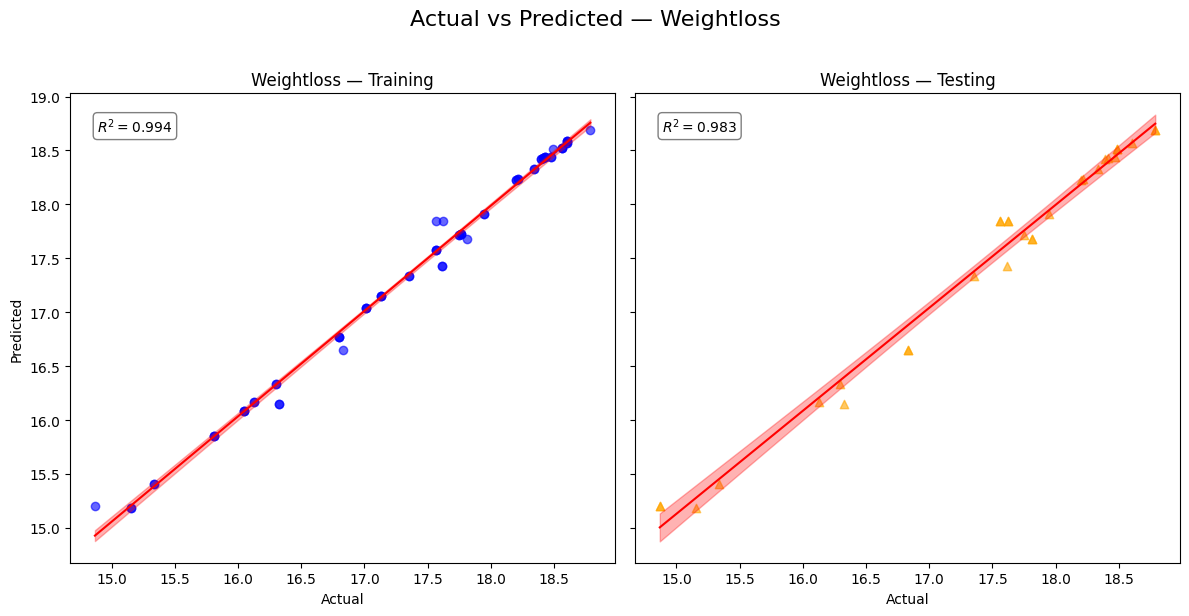

Saved plot to actual_vs_pred_Firmness.png


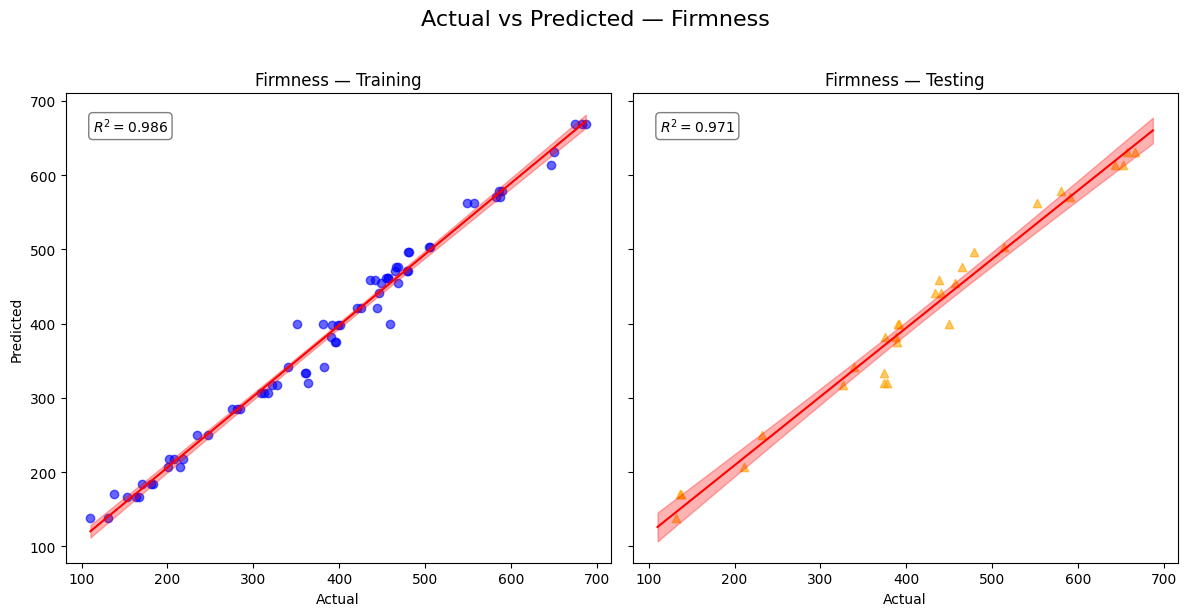

Saved plot to actual_vs_pred_TSS.png


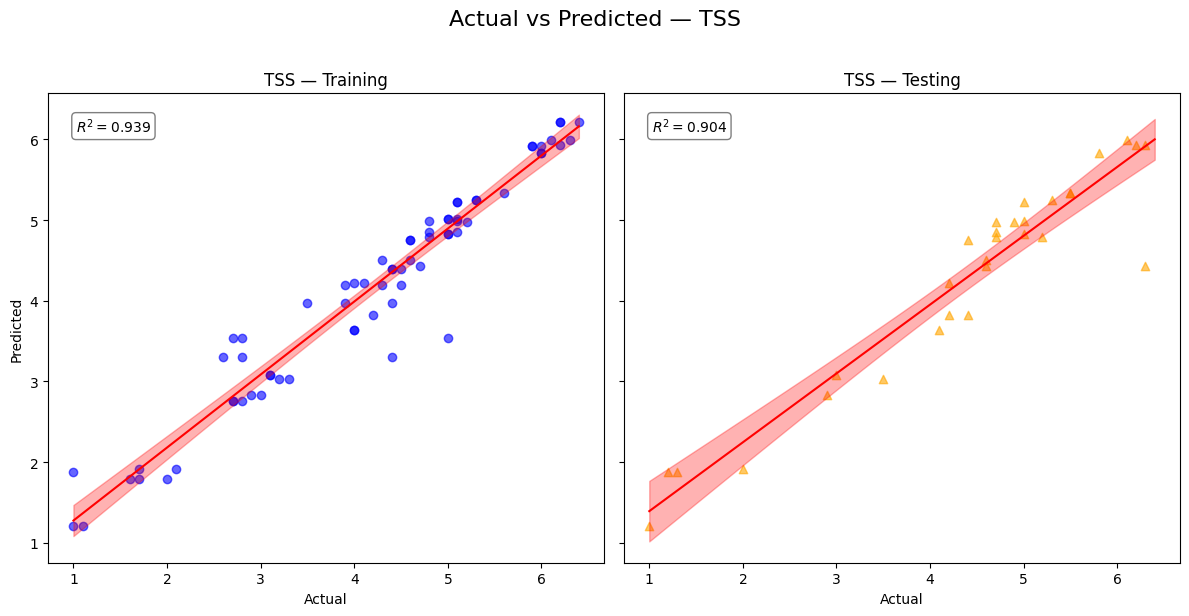

Saved plot to actual_vs_pred_pH.png


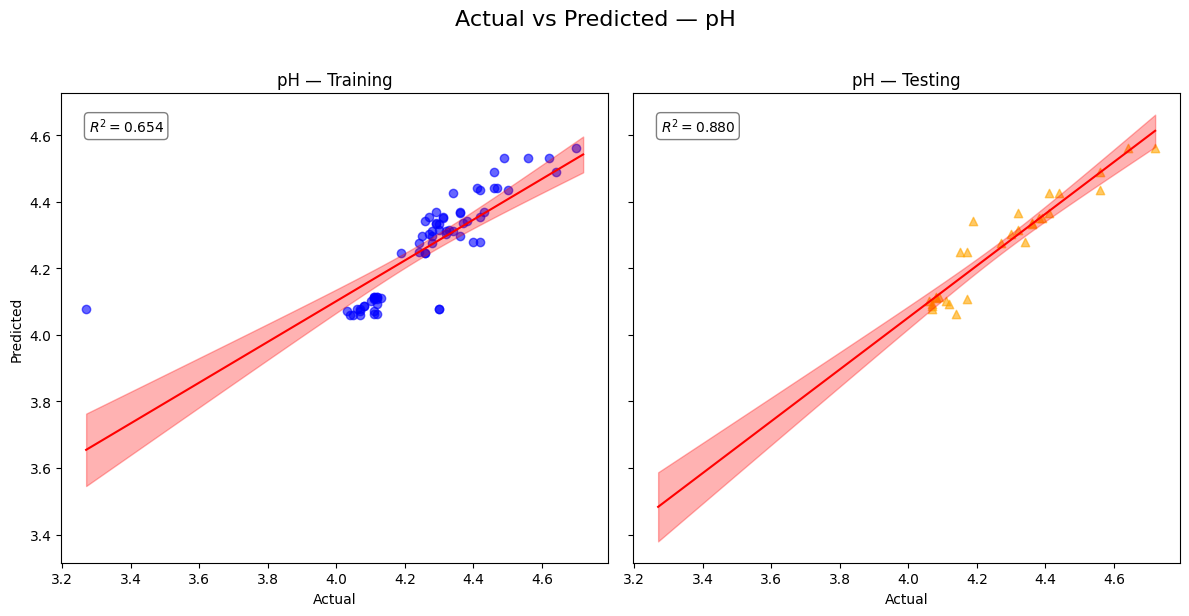

Saved plot to actual_vs_pred_L.png


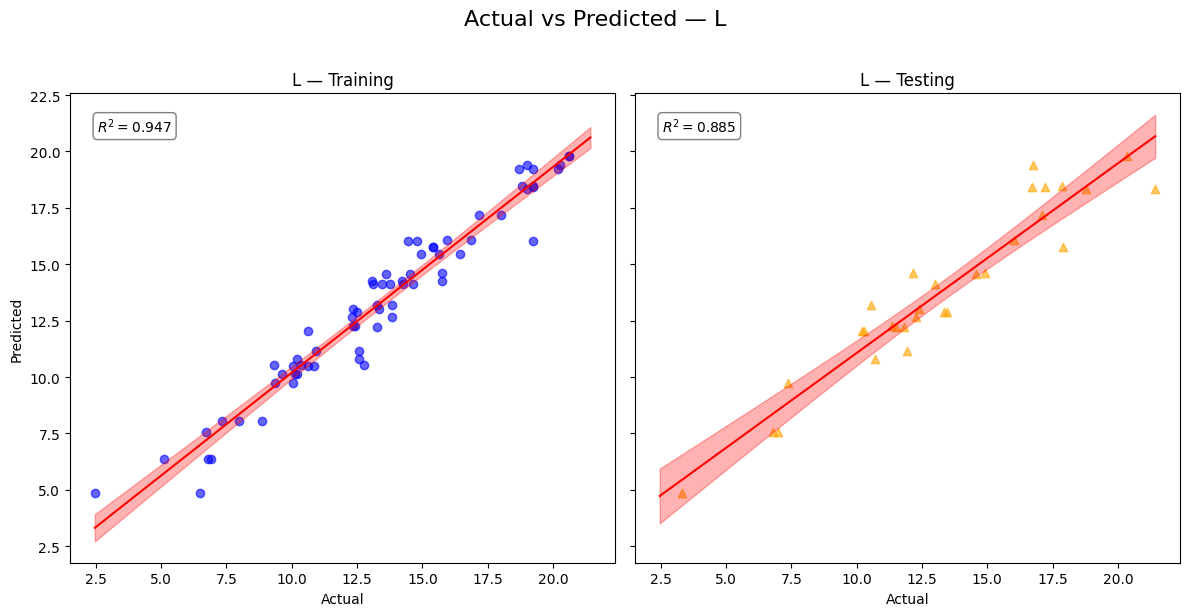

Saved plot to actual_vs_pred_a.png


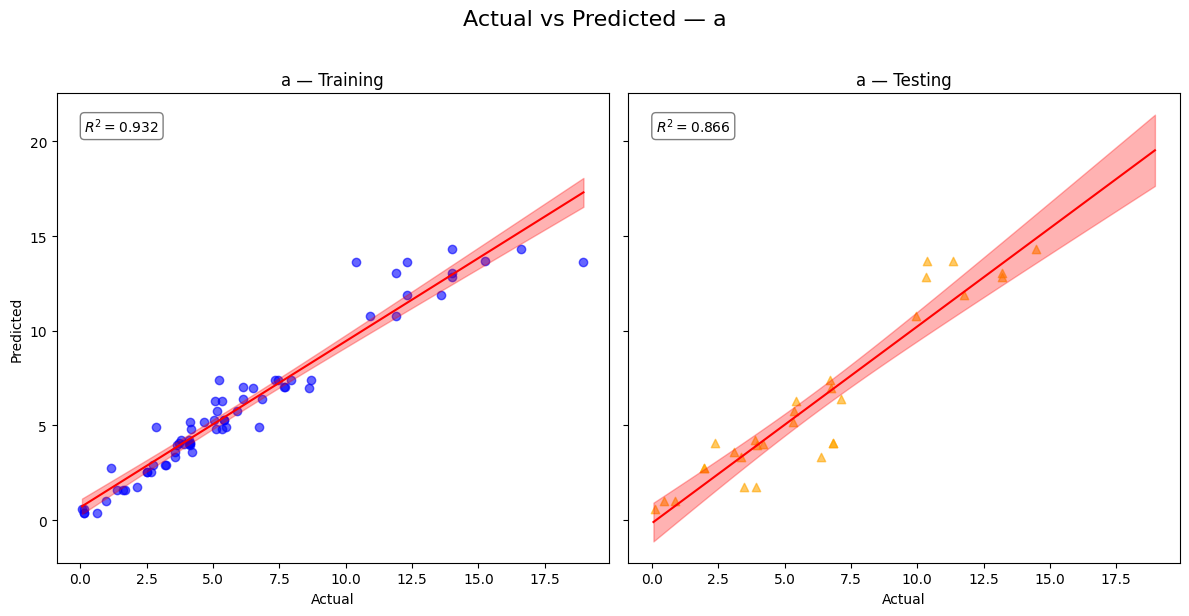

Saved plot to actual_vs_pred_b.png


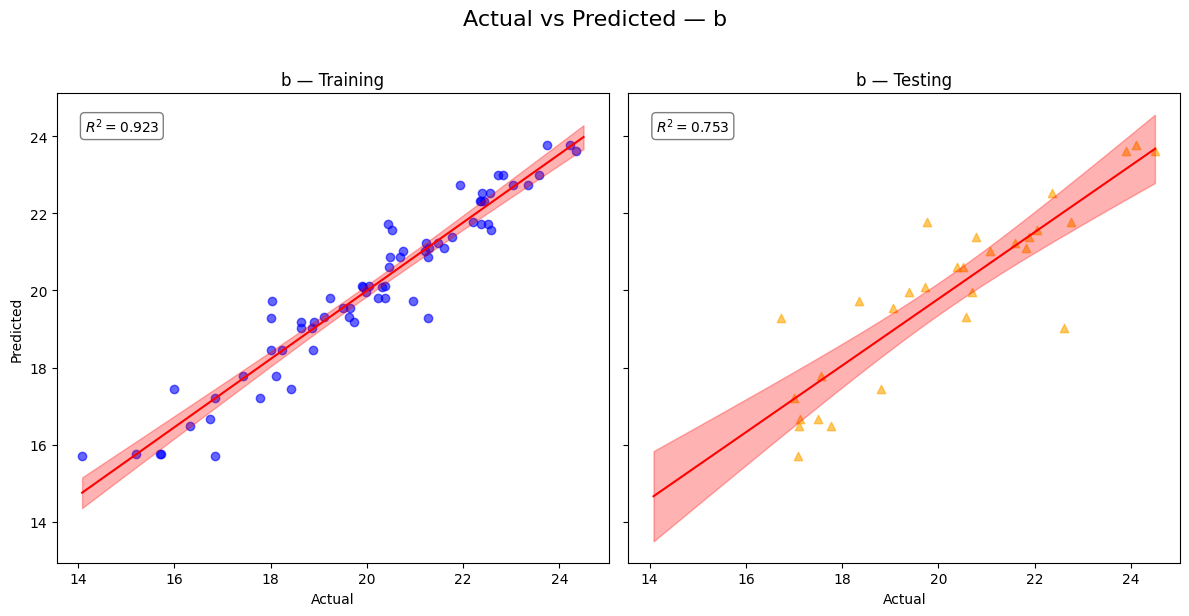

Saved plot to actual_vs_pred_ΔE.png


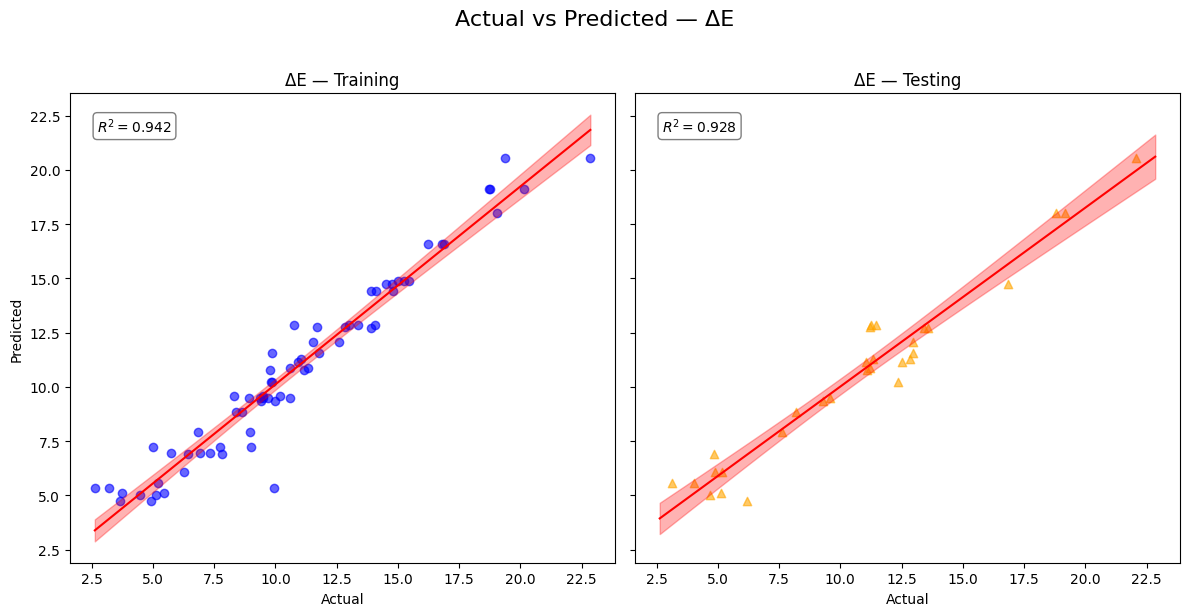

Saved plot to actual_vs_pred_TPC.png


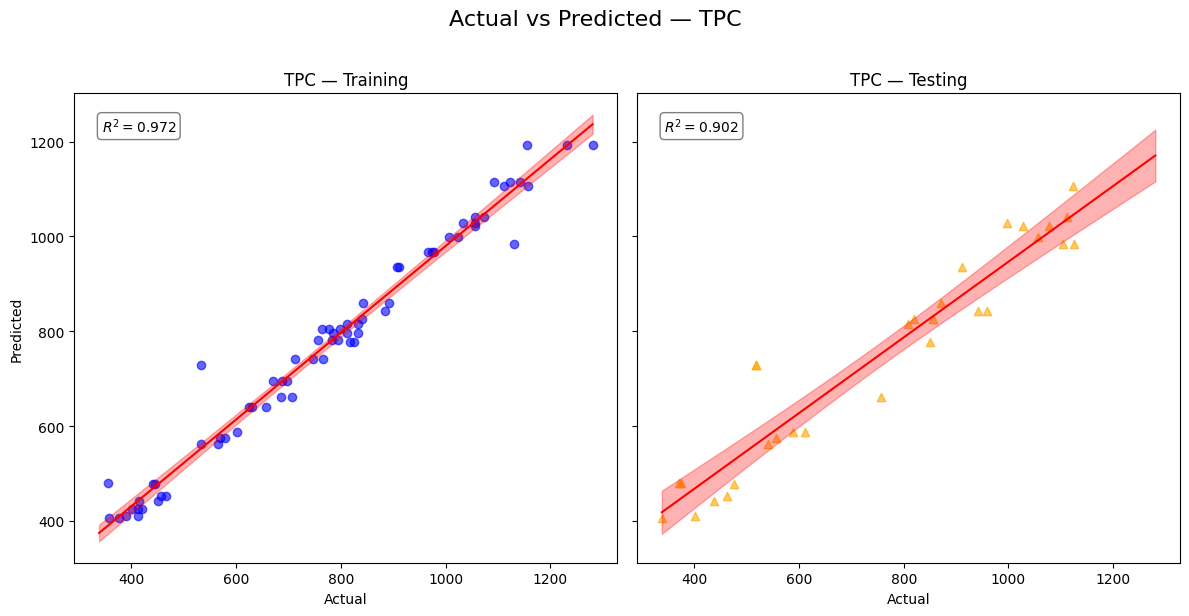

Saved plot to actual_vs_pred_inhibition.png


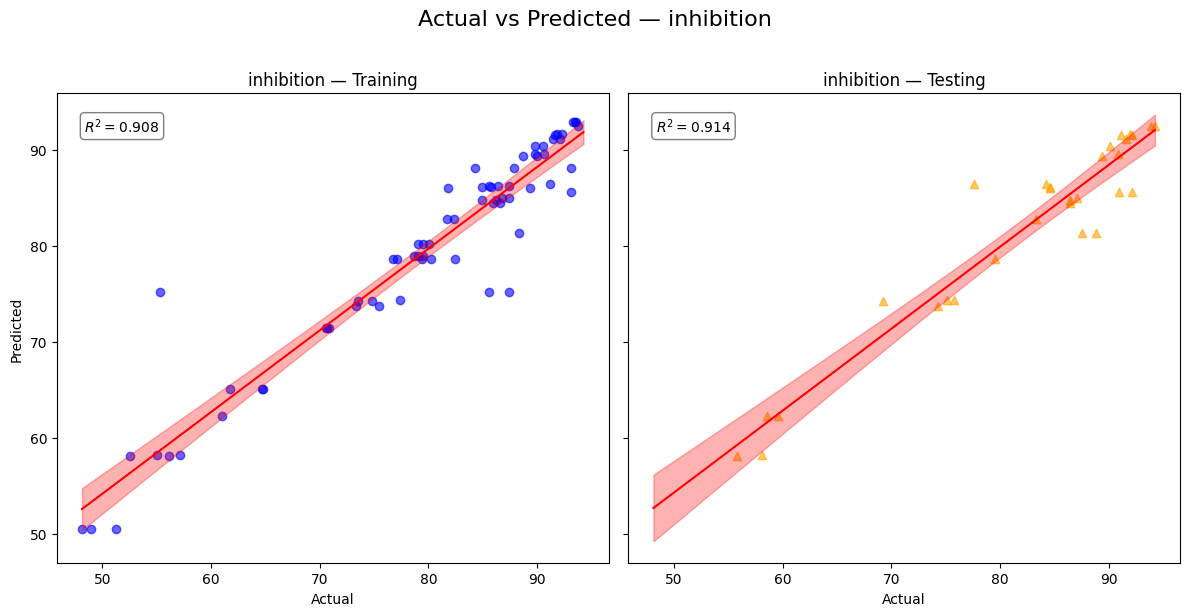

In [53]:
# In[3]: Plot Actual vs Predicted with R² inside the plots
for idx, name in enumerate(target_names):
    # Actual & predicted arrays for this target
    y_tr, yp_tr = y_train_arr[:, idx], y_train_pred[:, idx]
    y_te, yp_te = y_test_arr[:, idx],  y_test_pred[:, idx]

    # Compute R² scores
    r2_tr = r2_score(y_tr, yp_tr)
    r2_te = r2_score(y_te, yp_te)

    # Shared axis limits
    mn, mx = min(y_tr.min(), y_te.min()), max(y_tr.max(), y_te.max())
    xg = np.linspace(mn, mx, 100)

    # Fit OLS on train points for CI ribbon
    ols_tr = sm.OLS(yp_tr, sm.add_constant(y_tr)).fit()
    ci_tr  = ols_tr.get_prediction(sm.add_constant(xg)).summary_frame(alpha=0.05)

    # Fit OLS on test points for CI ribbon
    ols_te = sm.OLS(yp_te, sm.add_constant(y_te)).fit()
    ci_te  = ols_te.get_prediction(sm.add_constant(xg)).summary_frame(alpha=0.05)

    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    # --- Training panel (blue) ---
    ax1.scatter(y_tr, yp_tr, color='blue', alpha=0.6)
    ax1.plot(xg, ci_tr['mean'], color='red')
    ax1.fill_between(xg,
                     ci_tr['mean_ci_lower'],
                     ci_tr['mean_ci_upper'],
                     color='red', alpha=0.3)
    ax1.set_title(f'{name} — Training')
    ax1.set_xlabel('Actual')
    ax1.set_ylabel('Predicted')
    ax1.text(0.05, 0.95, f'$R^2={r2_tr:.3f}$',
             transform=ax1.transAxes,
             va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.5))

    # --- Testing panel (orange) ---
    ax2.scatter(y_te, yp_te, color='orange', marker='^', alpha=0.6)
    ax2.plot(xg, ci_te['mean'], color='red')
    ax2.fill_between(xg,
                     ci_te['mean_ci_lower'],
                     ci_te['mean_ci_upper'],
                     color='red', alpha=0.3)
    ax2.set_title(f'{name} — Testing')
    ax2.set_xlabel('Actual')
    ax2.text(0.05, 0.95, f'$R^2={r2_te:.3f}$',
             transform=ax2.transAxes,
             va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.5))

    plt.suptitle(f'Actual vs Predicted — {name}', y=1.02, fontsize=16)
    plt.tight_layout()
        # Save the figure
    filename = f"actual_vs_pred_{name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved plot to {filename}")

    plt.show()


In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [63]:
# Flatten all outputs
y_true_all_train = y_train_arr.ravel()
y_pred_all_train = y_train_pred.ravel()
y_true_all_test  = y_test_arr.ravel()
y_pred_all_test  = y_test_pred.ravel()

# Compute overall MSE and derive RMSE
mse_train  = mean_squared_error(y_true_all_train, y_pred_all_train)
rmse_train = np.sqrt(mse_train)
mae_train  = mean_absolute_error(y_true_all_train, y_pred_all_train)

mse_test   = mean_squared_error(y_true_all_test,  y_pred_all_test)
rmse_test  = np.sqrt(mse_test)
mae_test   = mean_absolute_error(y_true_all_test,  y_pred_all_test)

print("Overall Training Metrics:")
print(f"  MSE:  {mse_train:.3f}")
print(f"  RMSE: {rmse_train:.3f}")
print(f"  MAE:  {mae_train:.3f}\n")

print("Overall Testing Metrics:")
print(f"  MSE:  {mse_test:.3f}")
print(f"  RMSE: {rmse_test:.3f}")
print(f"  MAE:  {mae_test:.3f}")

Overall Training Metrics:
  MSE:  208.634
  RMSE: 14.444
  MAE:  4.511

Overall Testing Metrics:
  MSE:  748.618
  RMSE: 27.361
  MAE:  8.503


In [64]:
cv_mse  = mean_squared_error(y_true_all, y_pred_all)
cv_rmse = np.sqrt(cv_mse)
cv_mae  = mean_absolute_error(y_true_all, y_pred_all)
cv_r2   = r2_score(y_true_all, y_pred_all)

print("Overall CV Metrics:")
print(f"  MSE:  {cv_mse:.3f}")
print(f"  RMSE: {cv_rmse:.3f}")
print(f"  MAE:  {cv_mae:.3f}")
print(f"  R²:   {cv_r2:.3f}")

Overall CV Metrics:
  MSE:  748.618
  RMSE: 27.361
  MAE:  8.503
  R²:   0.989


In [78]:
all_means = []
all_stds  = []
for idx, name in enumerate(target_names):
    model = best_models[name]
    result = permutation_importance(
        model,
        X_test,
        y_test_arr[:, idx],
        n_repeats=10,
        random_state=0,
        n_jobs=-1
    )
    all_means.append(result.importances_mean)
    all_stds.append(result.importances_std)

In [79]:
# 2) Average across targets
mean_importance = np.mean(all_means, axis=0)
std_importance  = np.mean(all_stds,  axis=0)  # or np.sqrt(np.mean(np.array(all_stds)**2,axis=0))

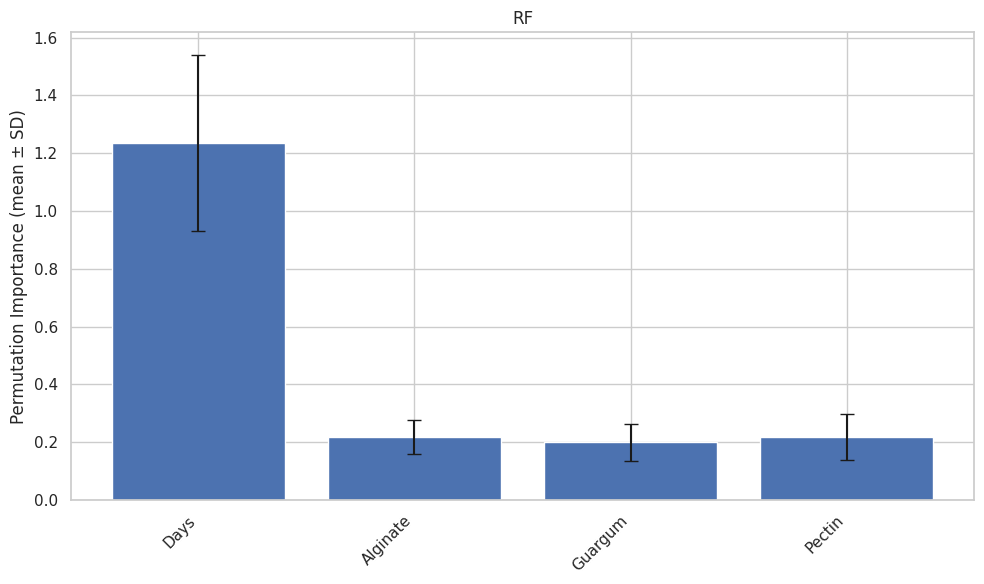

In [80]:
# 3) Plot with error‐bars
plt.figure(figsize=(10, 6))
plt.bar(
    range(len(feature_names)),
    mean_importance,
    yerr=std_importance,
    capsize=5   # little horizontal caps on the error bars
)
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.ylabel('Permutation Importance (mean ± SD)')
plt.title('RF')
plt.tight_layout()
filename = f"RF PI.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


In [72]:
import seaborn as sns

<ipython-input-77-db1fd9274087>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(


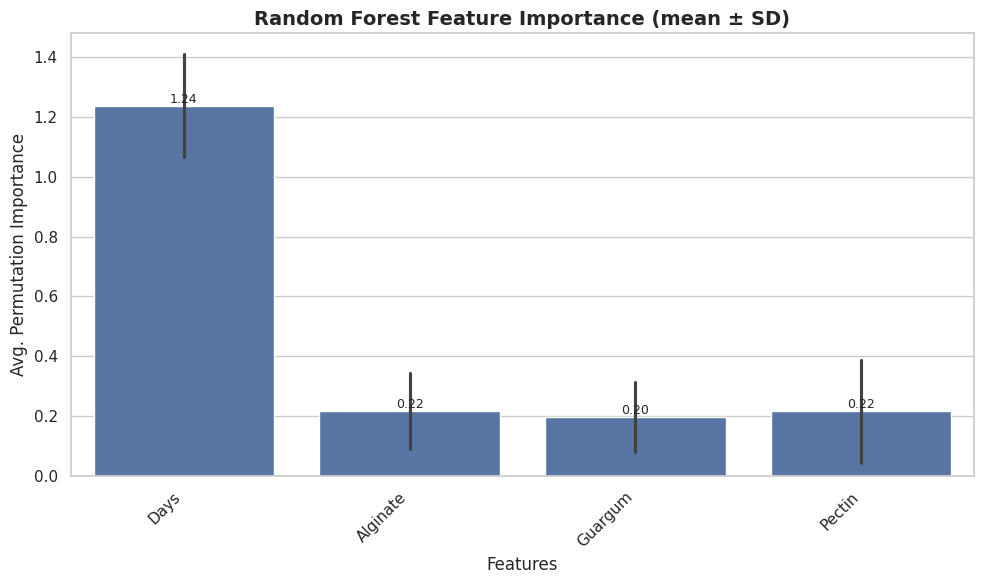

In [77]:
all_importances = []
for idx, name in enumerate(target_names):
    result = permutation_importance(
        best_models[name],
        X_test,
        y_test_arr[:, idx],
        n_repeats=10,
        random_state=0,
        n_jobs=-1
    )
    all_importances.append(result.importances_mean)

# 2) Build DataFrame of importances: rows=targets, cols=features
feature_names = X_test.columns.tolist()
df_imp = pd.DataFrame(all_importances, columns=feature_names, index=target_names)

# Melt to long format for seaborn
df_long = df_imp.reset_index().melt(id_vars='index', var_name='feature', value_name='importance')

# 3) Plot with seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_long,
    x='feature',
    y='importance',
    ci='sd',                # show ±1 SD error bars
    estimator=np.mean
)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=9)

ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("Avg. Permutation Importance", fontsize=12)
ax.set_title("Random Forest Feature Importance (mean ± SD)", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save and display
plt.savefig("RF_permutation_importance_seaborn.png", dpi=300, bbox_inches='tight')
plt.show()

In [85]:
from sklearn.model_selection import ShuffleSplit

In [86]:
def five_two_cv_scores(model, X, y, random_states=[0,1,2,3,4]):
    scores = []
    rs = ShuffleSplit(n_splits=1, test_size=0.5, random_state=None)
    for rs_state in random_states:
        # Split 1
        rs.random_state = rs_state
        for train_idx, test_idx in rs.split(X):
            # First fold
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[test_idx])
            scores.append(np.sqrt(mean_squared_error(y[test_idx].ravel(), y_pred.ravel())))
            # Reverse fold
            model.fit(X[test_idx], y[test_idx])
            y_pred = model.predict(X[train_idx])
            scores.append(np.sqrt(mean_squared_error(y[train_idx].ravel(), y_pred.ravel())))
    return np.array(scores)